In [2]:
import ee

import pandas as pd 
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer 
from sklearn.metrics import matthews_corrcoef, roc_auc_score, plot_confusion_matrix

## Load Land Classification Data 

In [3]:
df = pd.read_csv("landclass_locust.csv")
df.head(5)

,lat,long,date,lcc
0,-0.559788,37.478215,4/7/2021,Cultivated and managed vegetation/agriculture ...
1,-2.441984,40.161785,7/13/2020,"Open forest, unknown"
2,-0.651670,38.402958,4/4/2021,Urban / built up
3,-0.610328,38.112466,2/5/2021,Cultivated and managed vegetation/agriculture ...
4,0.120728,37.069462,2/11/2021,Cultivated and managed vegetation/agriculture ...


The `date` column needs to be parsed as a date object:

In [5]:
df['date'] = pd.DatetimeIndex(df['date'])
df.head(5)

,lat,long,date,lcc
0,-0.559788,37.478215,2021-04-07,Cultivated and managed vegetation/agriculture ...
1,-2.441984,40.161785,2020-07-13,"Open forest, unknown"
2,-0.651670,38.402958,2021-04-04,Urban / built up
3,-0.610328,38.112466,2021-02-05,Cultivated and managed vegetation/agriculture ...
4,0.120728,37.069462,2021-02-11,Cultivated and managed vegetation/agriculture ...


Count of Land Cover Classification (LCC) values:

In [6]:
df["lcc"].value_counts()

Cultivated and managed vegetation/agriculture (cropland)    300
Open forest, unknown                                        300
Urban / built up                                            300
Name: lcc, dtype: int64

Plot the data in a map of Kenya

<AxesSubplot:>

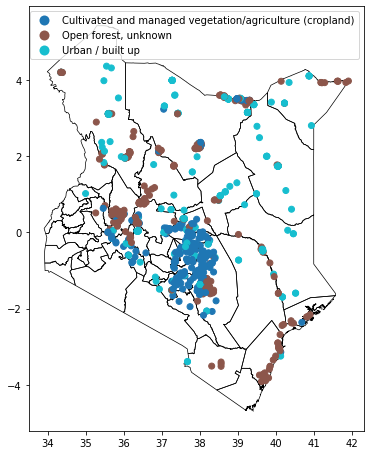

In [7]:
kenya = gpd.read_file("kenya_shapefile/County.shp")
gdf = gpd.GeoDataFrame(
    df,
    crs=4326,
    geometry=[Point(xy) for xy in zip(df.long, df.lat)])

fig, ax = plt.subplots(1, 1, figsize=(6, 10))

kenya.plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)
gdf.plot(column="lcc", ax=ax, legend=True)

## Extract Sentinel2 Band Values to Points

The next several cells are *optional*. If you have a [Google Earth Engine (GEE) account](https://signup.earthengine.google.com/), you can run the code to login to GEE, download the Sentinel2 data, and convert it into a data frame. In the interest of time, we'll use cached data from a CSV file.

In [ ]:
ee.Authenticate()

In [11]:
ee.Initialize()

Create two date columns to define the date period of the Sentinel2 images:

In [12]:
df['date_min'] = df['date'] -  pd.to_timedelta(16, unit='d')
df['date_max'] = df['date'] +  pd.to_timedelta(16, unit='d')
df.head()

,lat,long,date,lcc,geometry,date_min,date_max
0,-0.559788,37.478215,2021-04-07,Cultivated and managed vegetation/agriculture ...,POINT (37.47821 -0.55979),2021-03-22,2021-04-23
1,-2.441984,40.161785,2020-07-13,"Open forest, unknown",POINT (40.16179 -2.44198),2020-06-27,2020-07-29
2,-0.651670,38.402958,2021-04-04,Urban / built up,POINT (38.40296 -0.65167),2021-03-19,2021-04-20
3,-0.610328,38.112466,2021-02-05,Cultivated and managed vegetation/agriculture ...,POINT (38.11247 -0.61033),2021-01-20,2021-02-21
4,0.120728,37.069462,2021-02-11,Cultivated and managed vegetation/agriculture ...,POINT (37.06946 0.12073),2021-01-26,2021-02-27


In [14]:
def extract_to_point(x):
    bands_s2 = ["B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9"]
    lat = x["lat"]
    long = x["long"]
    p = ee.Geometry.Point([long,lat])
    
    # Select image based on following criteria:
    # * within the date range we defined
    # * sort all images by cloud cover 
    # * select images containing our point of image
    # * least cloud-covered images
    
    img = ee.ImageCollection("COPERNICUS/S2_SR") \
            .filterDate(x["date_min"].strftime("%Y-%m-%d"), x["date_max"].strftime("%Y-%m-%d")) \
            .sort("CLOUD_COVER") \
            .filterBounds(p) \
            .first()
    try: 
        # extract value from the above image to the point of interest
        temp = img.select(bands_s2).sampleRegions(collection=p, scale=10, geometries=True)
        info = temp.getInfo()
        print("info: ", info)
        print(" ")
        values = tt['features'][0]['properties']
        print("values: ", values)
        print(" ")
    except:
        values = {
          "B11": 0, "B12": 0, "B2": 0, "B3": 0, "B4": 0, 
          "B5": 0, "B6": 0, "B7": 0, "B8": 0, "B8A": 0, 
          "B9":0 }
    return values

DO NOT run the cell command for the interest of time.

In [ ]:
# result = df.apply(extract_to_point, axis=1, result_type="reduce")
# s2 = pd.DataFrame(result.tolist())
# s2["lat"] = df["lat"]
# s2["long"] = df["long"]
# s2["date"] = df["date"]
# s2["lcc"] = df["lcc"]

An example showing what extract_to_point function is doing:

In [15]:
example = df.iloc[3:5, :].apply(extract_to_point, axis=1, result_type="reduce")
example

info:  {'type': 'FeatureCollection', 'columns': {}, 'properties': {'band_order': ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']}, 'features': [{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [38.11249945740845, -0.6103030751136557]}, 'id': '0_0', 'properties': {'B11': 5513, 'B12': 4047, 'B2': 8312, 'B3': 7856, 'B4': 7484, 'B5': 7680, 'B6': 7510, 'B7': 7600, 'B8': 7404, 'B8A': 7480, 'B9': 6623}}]}
 
info:  {'type': 'FeatureCollection', 'columns': {}, 'properties': {'band_order': ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']}, 'features': [{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [37.0694261052473, 0.12075782690290773]}, 'id': '0_0', 'properties': {'B11': 2380, 'B12': 1587, 'B2': 518, 'B3': 739, 'B4': 929, 'B5': 1350, 'B6': 1918, 'B7': 2214, 'B8': 2194, 'B8A': 2425, 'B9': 2350}}]}
 


3    {'B11': 0, 'B12': 0, 'B2': 0, 'B3': 0, 'B4': 0...
4    {'B11': 0, 'B12': 0, 'B2': 0, 'B3': 0, 'B4': 0...
dtype: object

**Back to mandatory code**

For the interest of time, use cached data for the s2 dataset.

In [16]:
s2 = pd.read_csv("s2.csv")
display(s2.head(5))
s2["NDVI"] = (s2["B8"] - s2["B4"]) / (s2["B8"] + s2["B4"])
s2.drop(["lat", "long", "date"], axis=1, inplace=True)
lcc_code = {
  "Cultivated and managed vegetation/agriculture (cropland)": 0, 
  "Urban / built up": 1, 
  "Open forest, unknown": 2
}

s2["lcc"] = s2["lcc"].map(lcc_code)

s2.head(5)

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,lcc,lat,long,date
0,2392,2050,563,781,1204,1488,1995,2187,2195,2346,2440,Cultivated and managed vegetation/agriculture ...,-0.559788,37.478215,2021-04-07
1,2516,1747,306,684,635,1640,3075,3468,3276,3883,3652,"Open forest, unknown",-2.441984,40.161785,2020-07-13
2,5044,4512,3978,4042,4152,4386,4355,4456,4624,4654,6188,Urban / built up,-0.651670,38.402958,2021-04-04
3,5513,4047,8312,7856,7484,7680,7510,7600,7404,7480,6623,Cultivated and managed vegetation/agriculture ...,-0.610328,38.112466,2021-02-05
4,2380,1587,518,739,929,1350,1918,2214,2194,2425,2350,Cultivated and managed vegetation/agriculture ...,0.120728,37.069462,2021-02-11


,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,lcc,NDVI
0,2392,2050,563,781,1204,1488,1995,2187,2195,2346,2440,0,0.291556
1,2516,1747,306,684,635,1640,3075,3468,3276,3883,3652,2,0.675275
2,5044,4512,3978,4042,4152,4386,4355,4456,4624,4654,6188,1,0.053783
3,5513,4047,8312,7856,7484,7680,7510,7600,7404,7480,6623,0,-0.005373
4,2380,1587,518,739,929,1350,1918,2214,2194,2425,2350,0,0.405059


XGBoost Model 

Split X_train, X_test, y_train, y_test

In [17]:
X = s2.drop(["lcc"], axis=1)
y = s2["lcc"]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

SyntaxError: invalid syntax (<ipython-input-17-e5be79608bac>, line 1)

Define searching grids and other parameters in GridSearchCV

In [ ]:
estimator = XGBClassifier(
    objective="multi:softprob",
    tree_method="hist",
    seed=42,
    nthread=-1,
)

kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1234)

parameters = {
    #"eta" : [0.025, 0.5, 0.1],
    "max_depth": [6, 8, 10],
    "n_estimators": range(50, 100, 10),   
    "learning_rate": [0.1, 0.01, 0.05],
    #"min_child_weight": [1, 3, 5],
    #"gamma": [0, 0.5, 1],
    #"subsample": np.arange(0.6, 0.9, 0.1),
    #"colsample_bytree": [0.5, 0.75, 1.0],
    #"reg_alpha": [1e-5, 1e-2, 0.1, 1, 100]
}

fit_params = {
    "early_stopping_rounds": 10,
    #"eval_metric": "mcc",
    'eval_set': [[X_test, y_test]]
}

mcc_scorer = make_scorer(matthews_corrcoef)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring=mcc_scorer,
    cv=kfold,
    verbose=True#,
    #n_jobs=2 #-1
)

Fit the model

In [ ]:
grid_search.fit(X_train, y_train, **fit_params)

Let's see the best parameters found 

In [ ]:
grid_search.best_params_

Let's see the accuracy 

In [ ]:
accuracy_score(y_test, grid_search.predict(X_test))

Let's see the confusion matrix

In [ ]:
disp = plot_confusion_matrix(
    grid_search, X_test, y_test, 
    cmap=plt.cm.Blues,
    display_labels=["cropland", "urban", "forest"])
disp.ax_.set_title("XGBoost Confusion Matrix")
plt.show()

Feature importance

In [ ]:
grid_search.best_estimator_.feature_importances_

plt.bar(x=X_train.columns, height=grid_search.best_estimator_.feature_importances_)
plt.title("Feature Importance")
plt.show()

Bonus: how to extract time-series Sentinel2 data to points

First get a small subset of the entire dataset to save time

In [ ]:
df.sort_values(by=["date"], inplace=True)
subset = df.iloc[:5, :3]
subset

In [ ]:
bands_s2 = ["B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9"]

def extract_timeseries_to_point(x):
    lat = x["lat"]
    long = x["long"]
    p = ee.Geometry.Point([long,lat])
    
    # Create an image collection with 6-month's sentinel2 images, one for each month
    d = x["date"]
    date_list = [(d + timedelta(30*i)).strftime('%Y-%m-%d') for i in range(-3, 4)]
    image_ls = []
    for i in range(0, 6):
        s =  ee.ImageCollection("COPERNICUS/S2_SR")\
               .filterDate(date_list[i], date_list[i+1])\ 
               .sort("CLOUD_COVER")\
               .filterBounds(p)
               .first()
        image_ls.append(s)
    img_col = ee.ImageCollection(image_ls)
    
    # Extract values from the image collection to the point of interest and save to a csv
    def extract(img):
        return img.select(bands_s2).sampleRegions(collection=p, scale=10, geometries=True)
    
    newft = ee.FeatureCollection(img_col.map(extract)).flatten()
    f = newft.getInfo()["features"]
    keys = f[0]["properties"].keys()
    values = zip(
      f[0]["properties"].values(),
      f[1]["properties"].values(), 
      f[2]["properties"].values(),
      f[3]["properties"].values(),
      f[4]["properties"].values(),
      f[5]["properties"].values())
    dictionary = dict(zip(keys, values))
    
    display(pd.DataFrame.from_dict(dictionary))
    pd.DataFrame.from_dict(dictionary).to_csv(f"timeseries/df_{long}_{lat}_{d.strftime('%Y-%m-%d')}.csv")
    
    return 1

In [ ]:
subset.apply(extract_timeseries_to_point, axis=1)